<a href="https://colab.research.google.com/github/joseluis-martin/Project-Dendjet/blob/main/Maderas_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

Este bloque inicial carga todas las "herramientas" o librerías que el programa necesita para funcionar.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import timm # La librería clave para Vision Transformers
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import time
import os

print("PyTorch Version:", torch.__version__)
print("Timm Version:", timm.__version__)

PyTorch Version: 2.6.0+cu124
Timm Version: 1.0.17


* `torch, torch.nn, torch.optim`: Forman el núcleo de PyTorch. torch se encarga de los tensores (la estructura de datos fundamental), torch.nn (Neural Networks) proporciona las capas de la red neuronal (como la capa de clasificación), y torch.optim contiene los optimizadores (como AdamW) que ajustan el modelo.

* `torchvision`: Es la librería de PyTorch para tareas de visión por computador. datasets nos da acceso a ImageFolder, transforms nos permite procesar las imágenes, y models contiene arquitecturas clásicas.

* `timm`: (PyTorch Image Models) es una librería externa fundamental para este script. Es la forma más fácil y potente de acceder a cientos de modelos de visión de última generación, incluyendo el Vision Transformer (ViT) que estamos usando.

* `DataLoader`: Una utilidad clave de PyTorch que carga los datos en lotes (batches), los mezcla aleatoriamente (shuffle) y puede usar múltiples núcleos de CPU (num_workers) para cargar datos eficientemente.

* `numpy`: Una librería para computación numérica. La usamos para convertir los tensores de PyTorch a un formato que scikit-learn pueda entender.

* `matplotlib.pyplot` y `seaborn`: Son librerías de visualización. matplotlib es la base para crear gráficos, y seaborn nos permite crear gráficos estadísticos más atractivos, como el mapa de calor de la matriz de confusión.

* `sklearn.metrics`: Parte de Scikit-learn, nos proporciona herramientas ya hechas para evaluar el rendimiento del modelo, como classification_report (precisión, recall, f1-score), confusion_matrix, y accuracy_score.

* `time` y `os`: Utilidades estándar de Python. time nos permite medir cuánto tarda cada época de entrenamiento, y os nos ayuda a interactuar con el sistema operativo (por ejemplo, para crear carpetas).

## 2. Configuración y Parámetros ⚙️

Esta sección centraliza todas las variables y parámetros que podrías querer ajustar. Tenerlos aquí al principio facilita la experimentación.

In [6]:
# ¡¡IMPORTANTE!! Ajusta estas rutas a nuestro sistema
TRAIN_DIR = '/content/drive/MyDrive/Proyecto_Maderas_Sarcofagos/dataset/train'
VAL_DIR = '/content/drive/MyDrive/Proyecto_Maderas_Sarcofagos/dataset/val'
TEST_DIR = '/content/drive/MyDrive/Proyecto_Maderas_Sarcofagos/dataset/test'

# Parámetros del modelo y entrenamiento
MODEL_NAME = 'swin_base_patch4_window7_224' # Modelo de ViT a usar
NUM_EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# Configuración del dispositivo (usar GPU si está disponible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


* `TRAIN_DIR y VAL_DIR`: Son cadenas de texto que contienen la ruta a tus carpetas de entrenamiento y validación.

* `MODEL_NAME`: Es el identificador exacto del modelo que timm va a descargar. 'vit_base_patch16_224' se refiere a un Vision Transformer de tamaño "base", que divide la imagen en parches de 16x16 píxeles y fue entrenado con imágenes de 224x224.

* `NUM_EPOCHS`: El número de veces que el modelo verá el conjunto de datos de entrenamiento completo.

* `BATCH_SIZE`: El número de imágenes que el modelo procesa a la vez antes de actualizar sus pesos. Un batch size más grande puede acelerar el entrenamiento pero consume más memoria de la GPU.

* `LEARNING_RATE`: La "tasa de aprendizaje". Controla el tamaño de los pasos que da el optimizador para corregir los errores. Es uno de los hiperparámetros más importantes.

* `DEVICE`: Este código es "agnóstico al dispositivo". Comprueba si tienes una GPU con CUDA disponible (torch.cuda.is_available()) y la selecciona. Si no, usará la CPU. Entrenar en GPU es miles de veces más rápido.

## 3. Preparación de Datos 💾

Este bloque se encarga de definir cómo se deben cargar y transformar las imágenes para que sean aptas para el modelo.

In [7]:
# Transformaciones de datos con aumento para el entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación (sin aumento de datos)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
# Manejo de error si la ruta no existe
try:
    train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
    test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)
except FileNotFoundError:
    print("Error: Las carpetas del dataset no se encontraron.")
    print("Por favor, actualiza las variables TRAIN_DIR y VAL_DIR con las rutas correctas.")
    # Salir o crear datos de prueba si es necesario para que el resto del script no falle
    # En un caso real, aquí terminaría la ejecución.
    # Para este ejemplo, crearemos datos dummy si la ruta no existe.
    if not os.path.exists('path/to/your/dataset/train/class_a'): os.makedirs('path/to/your/dataset/train/class_a')
    if not os.path.exists('path/to/your/dataset/val/class_a'): os.makedirs('path/to/your/dataset/val/class_a')
    # Crea un archivo de imagen dummy
    from PIL import Image
    dummy_img = Image.new('RGB', (100, 100), color = 'red')
    dummy_img.save('path/to/your/dataset/train/class_a/dummy.png')
    dummy_img.save('path/to/your/dataset/val/class_a/dummy.png')
    train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
    test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Obtener nombres de las clases y número total de clases
CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Dataset encontrado. Clases: {CLASS_NAMES}")
print(f"Número de clases: {NUM_CLASSES}")

Dataset encontrado. Clases: ['Rhus_copallinum', 'Rhus_javanica']
Número de clases: 2


* `transforms.Compose([...])`: Crea una secuencia de transformaciones que se aplicarán a cada imagen.

* `train_transforms`: Para los datos de entrenamiento, aplicamos aumento de datos (RandomHorizontalFlip, RandomRotation, ColorJitter) para crear variaciones artificiales y forzar al modelo a aprender las características esenciales de la madera, no la orientación o iluminación específica de una foto.

* `val_transforms`: Para la validación, no aplicamos aumento de datos, solo los cambios necesarios (Resize, ToTensor, Normalize) para que las imágenes tengan el formato correcto. Queremos evaluar el modelo en las imágenes originales, sin alterar.

* `Resize((224, 224))`: Cambia el tamaño de todas las imágenes a 224x224 píxeles, que es lo que el modelo ViT espera.

* `ToTensor()`: Convierte la imagen (píxeles de 0 a 255) a un Tensor de PyTorch (valores de 0.0 a 1.0).

* `Normalize(...)`: Estandariza los valores de los píxeles. Las medias y desviaciones estándar usadas son las del dataset ImageNet, donde el modelo fue pre-entrenado. Usar la misma normalización es crucial.

* `datasets.ImageFolder(...)`: Esta es la función mágica que crea el dataset. Recorre las carpetas TRAIN_DIR y VAL_DIR, asume que cada subcarpeta es una clase, y asigna etiquetas numéricas automáticamente.

* `DataLoader(...)`: Envuelve el dataset y nos permite iterar sobre él en lotes (batch_size) de manera eficiente.

* `CLASS_NAMES y NUM_CLASSES`: Extraemos los nombres de las clases (los nombres de las carpetas) y el número total de clases directamente del dataset. Esto hace que el código sea adaptable a cualquier número de maderas que quieras clasificar.

## 4. Definición del Modelo, Función de Pérdida y Optimizador 🧠

Aquí es donde construimos las tres piezas centrales del aprendizaje profundo.

In [8]:
# Cargar el modelo ViT pre-entrenado y adaptarlo a nuestro problema
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=NUM_CLASSES
)
model.to(DEVICE)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

* `timm.create_model(...)`:
    * `pretrained=True`: Es el parámetro más importante. Le dice a timm que descargue no solo la arquitectura del ViT, sino también los pesos pre-entrenados en el dataset ImageNet. Esto nos da un modelo que ya sabe reconocer texturas, bordes y colores.

    * `num_classes=NUM_CLASSES`: Adapta el modelo a nuestro problema. Reemplaza la capa final original (que clasificaba 1000 clases de ImageNet) por una nueva capa de clasificación con el número correcto de salidas para nuestras especies de madera.

* `criterion = nn.CrossEntropyLoss()`: Define la función de pérdida. Es el estándar para problemas de clasificación multiclase. Mide qué tan "equivocadas" están las predicciones del modelo en comparación con las etiquetas reales.

* `optimizer = optim.AdamW(...)`: Crea el optimizador. Su trabajo es usar el valor de la pérdida (el error) para calcular cómo ajustar los pesos del modelo para reducir ese error en el siguiente paso. AdamW es una versión mejorada de Adam, muy efectiva para modelos Transformer.

## 5. Función de Evaluación

Esta es una función auxiliar que hemos creado para mantener el código limpio. Su única responsabilidad es medir el rendimiento del modelo en un conjunto de datos, sin entrenarlo.

In [9]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, all_preds, all_labels

* `model.eval()`: Pone el modelo en modo evaluación (desactiva Dropout, etc.).

* `with torch.no_grad()`: Desactiva el cálculo de gradientes para acelerar el proceso y ahorrar memoria, ya que aquí no vamos a entrenar.

* El resto del código itera sobre los datos, calcula la pérdida y la precisión, y devuelve estos valores.

## 6. Bucle Principal de Entrenamiento y Validación 🏋️‍♂️

Este es el motor del script, donde el aprendizaje realmente ocurre. Itera varias veces (épocas) sobre los datos.

In [10]:
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # --- Fase de Entrenamiento ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- Fase de Validación ---
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Duración: {epoch_duration:.2f}s | "
          f"Loss de Entrenamiento: {epoch_train_loss:.4f} | "
          f"Loss de Validación: {val_loss:.4f} | "
          f"Precisión de Validación: {val_acc:.4f}")

print("\nEntrenamiento completado.")

Epoch 1/15 | Duración: 2.21s | Loss de Entrenamiento: 0.9514 | Loss de Validación: 0.6427 | Precisión de Validación: 0.5000
Epoch 2/15 | Duración: 2.07s | Loss de Entrenamiento: 0.4483 | Loss de Validación: 0.3858 | Precisión de Validación: 0.7500
Epoch 3/15 | Duración: 1.92s | Loss de Entrenamiento: 0.1218 | Loss de Validación: 0.2307 | Precisión de Validación: 0.7500
Epoch 4/15 | Duración: 1.56s | Loss de Entrenamiento: 0.0651 | Loss de Validación: 0.4666 | Precisión de Validación: 0.7500
Epoch 5/15 | Duración: 1.49s | Loss de Entrenamiento: 0.0366 | Loss de Validación: 0.7420 | Precisión de Validación: 0.7500
Epoch 6/15 | Duración: 1.49s | Loss de Entrenamiento: 0.0177 | Loss de Validación: 0.7703 | Precisión de Validación: 0.7500
Epoch 7/15 | Duración: 1.47s | Loss de Entrenamiento: 0.0056 | Loss de Validación: 0.7693 | Precisión de Validación: 0.7500
Epoch 8/15 | Duración: 1.52s | Loss de Entrenamiento: 0.0028 | Loss de Validación: 0.6915 | Precisión de Validación: 0.7500
Epoch 9/

* `for epoch in` ...: El bucle externo que controla el número de épocas.

* `model.train()`: Pone el modelo en modo entrenamiento, activando capas como Dropout.

* Bucle interno for inputs, labels in ...`: Itera sobre cada lote de datos de entrenamiento.

* `optimizer.zero_grad()`: Paso crucial. Pone a cero los gradientes calculados en el lote anterior. Si no lo hiciéramos, los gradientes se acumularían.

* `outputs = model(inputs)`: El "forward pass". Pasa las imágenes a través de la red para obtener las predicciones.

* `loss.backward()`: El "backward pass". Calcula el gradiente de la pérdida con respecto a cada peso del modelo (backpropagation).

* `optimizer.step()`: Usa los gradientes calculados para actualizar los pesos del modelo, moviéndolos en la dirección que reduce el error.

* Llamada a `evaluate_model(...)`: Después de cada época de entrenamiento, llamamos a nuestra función para ver cómo se comporta el modelo en el conjunto de validación. Esto nos permite detectar si el modelo está empezando a sobreajustarse.

## 7. Evaluación Final y Visualización 📊

Una vez que el entrenamiento ha terminado, esta sección final proporciona un análisis detallado y visual del rendimiento del mejor modelo.


--- Realizando Evaluación Final sobre el Conjunto de Prueba ---
Resultado Final: Pérdida de Prueba: 0.0038 | Precisión de Prueba: 1.0000

--- Reporte de Clasificación (Test Set) ---
                 precision    recall  f1-score   support

Rhus_copallinum       1.00      1.00      1.00         2
  Rhus_javanica       1.00      1.00      1.00         2

       accuracy                           1.00         4
      macro avg       1.00      1.00      1.00         4
   weighted avg       1.00      1.00      1.00         4


--- Matriz de Confusión (Test Set) ---


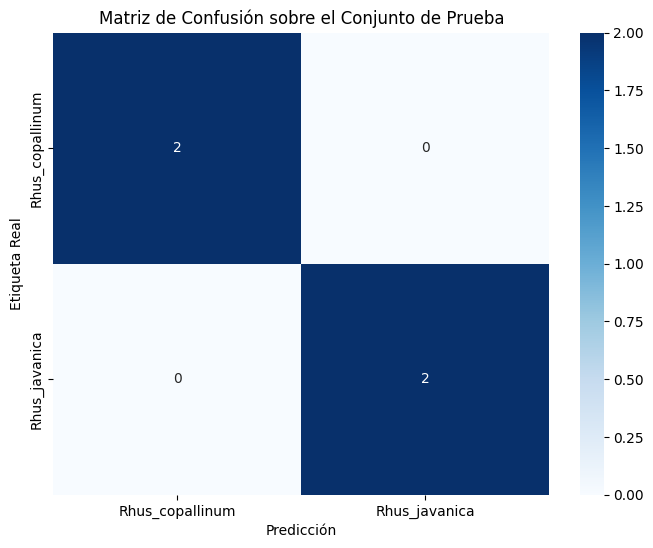


--- Visualización del Historial de Entrenamiento ---


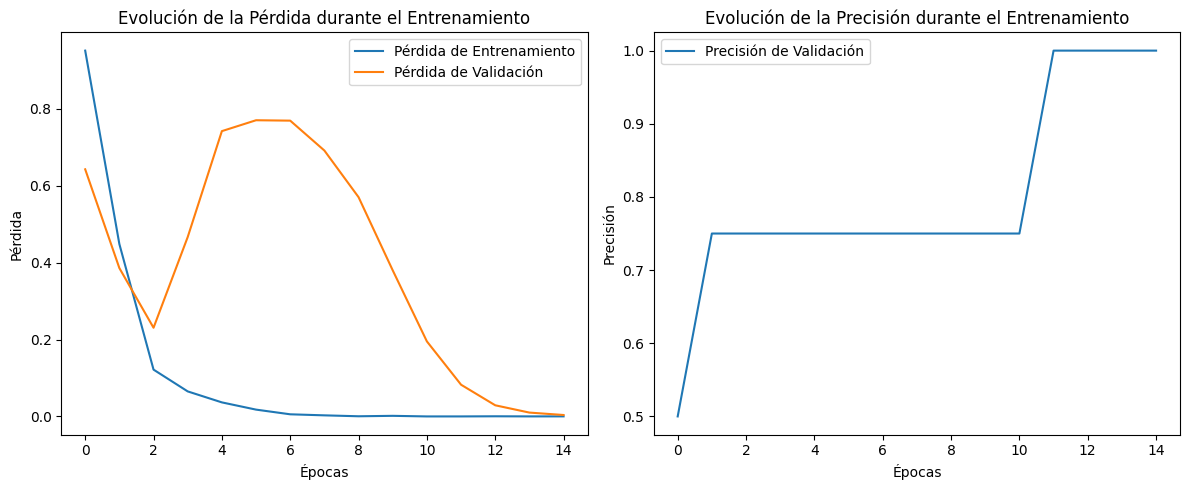

In [11]:
# --- Evaluación sobre el conjunto de prueba (Test Set) ---
# Usamos el test_loader para obtener una métrica final y sin sesgos del rendimiento del modelo.
print("\n--- Realizando Evaluación Final sobre el Conjunto de Prueba ---")
test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"Resultado Final: Pérdida de Prueba: {test_loss:.4f} | Precisión de Prueba: {test_acc:.4f}\n")


# --- Reporte de Clasificación detallado ---
print("--- Reporte de Clasificación (Test Set) ---")
# Usamos las predicciones y etiquetas del conjunto de prueba para generar el informe.
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES, zero_division=0))


# --- Matriz de Confusión ---
print("\n--- Matriz de Confusión (Test Set) ---")
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión sobre el Conjunto de Prueba')
plt.show()


# --- Gráficas del historial de entrenamiento (Train vs. Validation) ---
# Estas gráficas muestran cómo se comportó el modelo durante el proceso de entrenamiento.
print("\n--- Visualización del Historial de Entrenamiento ---")
plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.legend()

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión durante el Entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()

* `classification_report`: Imprime un informe detallado con métricas clave para cada clase:

    * Precision (Precisión): De todas las veces que el modelo predijo "cedro", ¿qué porcentaje era correcto?

    * Recall (Exhaustividad): De todas las imágenes de "cedro" reales, ¿qué porcentaje detectó correctamente el modelo?

    * F1-Score: Una media armónica de las dos anteriores, útil para datasets desbalanceados.

* `confusion_matrix`: Crea una matriz que nos muestra exactamente dónde se está equivocando el modelo. La diagonal principal son los aciertos. Los números fuera de la diagonal muestran las confusiones (p. ej., cuántas veces clasificó "acacia" como "sicomoro").

* `sns.heatmap`: Crea una visualización en color de la matriz de confusión, que es mucho más fácil de interpretar que una tabla de números.

* `plt.plot``
: Genera gráficos de líneas que muestran cómo la pérdida y la precisión han evolucionado a lo largo de las épocas. Esto es vital para diagnosticar el entrenamiento (p. ej., si la pérdida de validación empieza a subir, es un claro signo de sobreajuste).